# Tutorial for processing KOALA data with PyKOALA
# Using PyKOALA KOALA-specific tools
# 1. Intro and generic tasks

## Import tasks

In [1]:
# Import modules
# NOTE: All modules needed in this tutorial will be loaded HERE

# General modules
from matplotlib import pyplot as plt
import numpy as npx
import warnings
import importlib
# You may want to comment the following line
warnings.filterwarnings("ignore")

# PyKOALA modules
from pykoala import __version__
print("Running pyKOALA version: ", __version__)

from pykoala.instruments.koala_ifu import list_koala_fits_files_in_folder
from pykoala.instruments.koala_ifu import koalaRSS
from pykoala.plotting.quick_plot import quick_plot
from pykoala.plotting.rss_plot import rss_image, rss_map, get_spectrum, plot_wavelength

Running pyKOALA version:  0.11.1+38.g6aa3146.dirty


## Prepare the data 
& read RSS files already pre-processed with 2dFdr

In [2]:
aaomega_arms = {'blue': 1, 'red': 2}
aaomega_gratings = {'blue': "580V", 'red': "385R"}

# # Set the folder with the data
path_to_data = './data'
import os
os.system('pwd')

# # Set the date for AAT data files
date="27feb"

# # Choose which arm of the spectrograph is going to be used, it is best starting with the RED grating
arm = 'red'

# # If using name of the gratings as name of folder
path_to_filename = f"{path_to_data}/{aaomega_gratings[arm]}"

# # Check the data that we have in folder path_to_filename using task "list_koala_fits_files_in_folder()"
list_koala_fits_files_in_folder(path_to_data)


> Listing 2dFdr fits files in folder/home/mbolivar/koala/tutorials
 ./data :

  Skyflat          ./data/07sep10011red.fits          5.0 s
                   ./data/07sep10012red.fits          5.0 s
                   ./data/07sep10013red.fits          7.5 s
                   ./data/07sep10014red.fits          9.0 s
  HR7596           ./data/07sep10023red.fits          2.0 s
                   ./data/07sep10024red.fits          2.0 s
                   ./data/07sep10025red.fits          2.0 s
  NGC1311acq       ./data/07sep10060red.fits          60.0 s
  NGC1311          ./data/07sep10061red.fits          1200.0 s
                   ./data/07sep10062red.fits          1200.0 s
  HILT600          ./data/27feb20028red.fits          120.0 s
                   ./data/27feb20029red.fits          120.0 s
                   ./data/27feb20030red.fits          120.0 s
  Tol30            ./data/27feb20031red.fits          1200.0 s
  He2-10           ./data/27feb20032red.fits          1200.0 s
  

## Read rss file

The task koalaRSS(filename, rss_object_name = None, path=None, plot_map= False, **kwargs)
creates a KOALA rss object including rss.koala

NOTE: In PyKOALA, options "plot" (for plotting) and "verbose" (for printing in screen what it is doing)
       are always included in **kwargs. Same things for "warnings" (print only warnings)


> Converting KOALA+AAOmega RSS file "./data/27feb20028red.fits" to a koala RSS object...
[Log]  Initialising history log
[Log]  Initialising history log


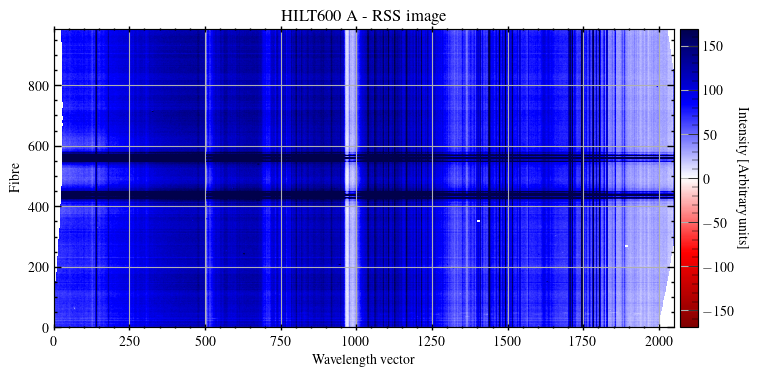

  Found 986 spectra with 2048 wavelengths between 6080.96 and 9305.36 Angstroms.
  This RSS file uses the 385R grating in the red AAOmega arm.
  The KOALA field of view is WIDE: 50.6" x 27.4", with a spaxel size of 1.25" and PA = 89.9º.
  Name of the observation = "HILT600 A",   Name of this Python RSS object = "run28_red".


In [3]:
# # Set obs_number to be read
obs_number = 28 #31-36  galaxy, 28, 29, 30 star 2, 25,26,27 star 1

# # Set variable "filename" just with the info of the file (it does not include the path in this example)
filename = f"{date}{aaomega_arms[arm]}00{obs_number}red.fits"        

run28_red = koalaRSS(filename,                         # Name of the file, it could including all full path
                     path = path_to_data,          # Path to the file (optional, default=None)
                     rss_object_name = "run28_red",    # Name of the rss object to be created (optional, default=None)
                     verbose = True,                   # Print in screen what it is happening (optional, default=False)
                     plot = True)                      # Plot any plot that appears in the process (optional, default=False)

## Check structure of the rss object

In [4]:
run28_red.wavelength  # Wavelength vector
run28_red.intensity   # Intensity in the form run28_red.intensity[fibre_index,wavelength_index]
run28_red.variance    # Variance in the form run28_red.variance[fibre_index,wavelength_index]
run28_red.info        # Dictionary with general info of the rss
run28_red.koala       # Object including specific koala information and variables

In [5]:
print(run28_red.wavelength)

[6080.9588623  6082.53404462 6084.10922693 ... 9302.20669104 9303.78187335
 9305.35705566]


In [6]:
print(run28_red.intensity)

[[76.03494  85.01237  71.432556 ...       nan       nan       nan]
 [62.802193 51.24656  48.788467 ...       nan       nan       nan]
 [69.09473  70.2224   75.24431  ...       nan       nan       nan]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]


In [8]:
print("Name of this rss :",run28_red.info["name"])        # Name of the observation, as taken at the telescope and included in fits file
print("Exposition time  :",run28_red.info["exptime"])     # Exposition time in s  
print("Airmass          :",run28_red.info["airmass"])     # Airmass
print(run28_red.info["fib_ra"])     # Absolute RA  position of fibres in sky (lists 986 values), in degrees
#print(run28_red.info["fib_dec"])    # Absolute DEC position of fibres in sky (lists 986 values), in degrees

Name of this rss : HILT600 A
Exposition time  : 120.0
Airmass          : 1.2271963296391781
[101.30856697 101.30856639 101.30856581 101.30856523 101.30856465
 101.30826361 101.30826419 101.30826477 101.30826535 101.30826592
 101.30796546 101.30796488 101.3079643  101.30796372 101.30796315
 101.3076621  101.30766268 101.30766326 101.30766384 101.30736279
 101.30736395 101.30736337 101.30766442 101.30736222 101.30736164
 101.30706059 101.30706117 101.30706175 101.30706233 101.30706291
 101.30676244 101.30676186 101.30676129 101.30676071 101.30676013
 101.30645908 101.30645966 101.30646024 101.30646082 101.3064614
 101.30616093 101.30616036 101.30615978 101.3061592  101.30615862
 101.30585758 101.30585816 101.30585873 101.30585931 101.30585989
 101.30555943 101.30555885 101.30555827 101.30555769 101.30555711
 101.30525607 101.30525665 101.30525723 101.3052578  101.30525838
 101.30495792 101.30495734 101.30495676 101.30495618 101.3049556
 101.30465456 101.30465514 101.30465572 101.3046563 

## Check the structure of KOALA object in rss

In [ ]:
# Now, check the koala object in rss:

run28_red.koala.info             # Dictionary with KOALA info
run28_red.koala.header           # Header of the fits file
run28_red.koala.wcs              # WCS info (astropy) using header
run28_red.koala.fibre_table      # Original fibre table of the fits file (as given by AAT but removing broken fibres)
run28_red.koala.history          # History of the fits file
run28_red.koala.corrections_done # Corrections done by PyKOALA in this rss file

run28_red.koala.integrated_fibre            # Integrated value of intensity in each fibre (array with 986 values)
run28_red.koala.integrated_fibre_variance   # Integrated value of variance in each fibre (array with 986 values)
run28_red.koala.integrated_fibre_sorted     # List of fibres from LOWEST to HIGHEST integrated value
run28_red.koala.negative_fibres             # List of fibres for which the integrated value of intensity is NEGATIVE


run28_red.koala.mask                        # List of 2 arrays, each on with 986 values. The first array lists the FIRST GOOD value, 
                                            # in wavelength_index, of each fibre, the second array lists the LAST GOOD value of fibre
run28_red.koala.list_fibres_all_good_values # List of fibres where ALL wavelength indeces are GOOD


run28_red.koala.emission_lines_gauss_spectrum                     # Here a 1D spectrum with the emission lines found running Gaussian
                                                                  # fits will be stored
run28_red.koala.redshifted_emission_lines_detected_dictionary     # The dictionary with the redshifted emission lines when created
run28_red.koala.continuum_model_after_sky_correction              # If created, the continuum model after sky correction will be there


In [9]:
# Check KOALA info:
for item in run28_red.koala.info: print(item,":",run28_red.koala.info[item])

rss_object_name : run28_red
path_to_file : ./data/27feb20028red.fits
n_wave : 2048
n_spectra : 986
spaxel_size : 1.25
aaomega_arm : red
aaomega_grating : 385R
aaomega_dichroic : X5700
KOALA_fov : WIDE: 50.6" x 27.4"
position_angle : 89.9177910093928
RA_centre_deg : 101.304946632813
DEC_centre_deg : 2.138343959215929
exptime : 120.0
description : None
valid_wave_min : 6121.91360242502
valid_wave_max : 9226.59794004716
valid_wave_min_index : 26
valid_wave_max_index : 1997
brightest_line : None
brightest_line_wavelength : None
history : None


As well as provide some quick info about KOALA + AAOmega (grating, dichroic, spaxel_size, FoV), this provides:
- The minimum valid wavelength (i.e., it has a value for ALL fibres) is 6121.91360242502 in wavelength index 26
- The maximum valid wavelength (i.e., it has a value for ALL fibres) is 9226.59794004716 in wavelength index 1997
- The brightest emission line we should in this object (typically H-alpha in red and H-beta or [OIII]5007 in blue)
- Its wavelength (redshifted, as measured here)
- history that we will add to the fits file when saved
- We have not provided an extra description for this file (we could if we want)

## Plotting spectra

For plotting a spectrum, we can use task get_spectrum(data_container, fibre=fibre, r=False, **kwargs)

In this example, we will plot the spectrum of the brightest fibre (the title of the plot will tell us its number), also indicating with vertical dashed lines valid_wave_min and valid_wave_max, as well as H-alpha in this star, and shading the region with the strong telluric absorption at ~7600 A.

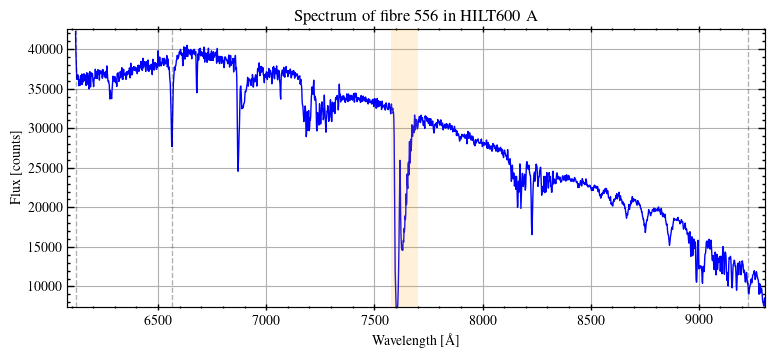

In [10]:
get_spectrum(run28_red,
             fibre = run28_red.koala.integrated_fibre_sorted[-1],       # Brightest fibre
             r = False,                                                 # The spectrum will NOT be returned
             plot=True,                                                 # Plot the spectrum
             axvspan = [[7575,7700]],                                   # Many options in quick_plot go in **kwargs
             vlines=[6563, run28_red.koala.info["valid_wave_min"],
                     run28_red.koala.info["valid_wave_max"]],
             )

We can also plot or obtain a spectrum combining several fibres using `plot_combined_spectrum(rss, list_spectra=None, median=False, r=False, **kwargs)`.

In this example, we add (using median = False) the 10 brightest fibres, and save it in bright_spectrum

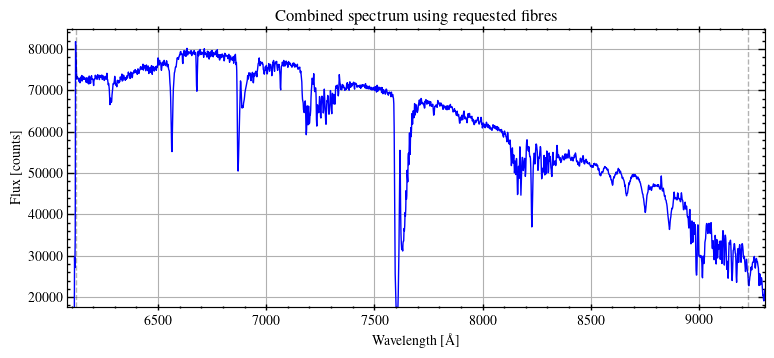

In [11]:
bright_spectrum = get_spectrum(run28_red,
                               list_fibre=run28_red.koala.integrated_fibre_sorted[-10:],  # List of fibres to be combined
                               median=False,                                              # If median = False, we sum all flux
                               plot = True,                                               # Plot it
                               r=True)                                                    # The spectrum WILL be returned

### Using quick_plot()

The task get_spectrum() uses the generic plotting task quick_plot().

This task has plenty of options. Check full info in the description of the task.

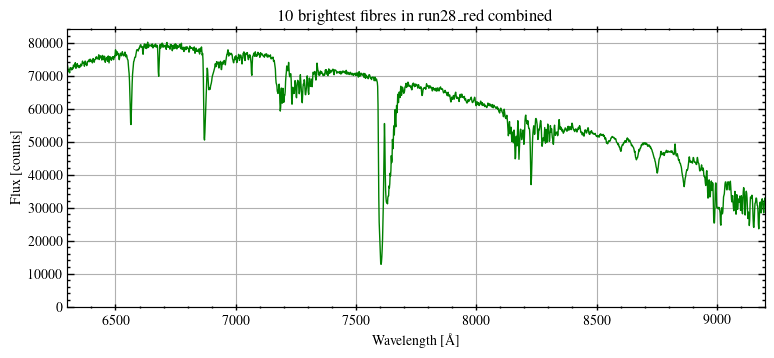

In [12]:
wr = run28_red.wavelength
#bright_spectrum = run28_red.intensity[run28_red.koala.integrated_fibre_sorted[-1]]

quick_plot(wr,                                                  # x vector (it can be a list matching the y vectors)
          bright_spectrum,                                      # y vector (or vector list using [spec1, spec2,...]
          ptitle="10 brightest fibres in run28_red combined",   # Title of the plot
          color = "green",                                      # color (or vector with colors matching y vectors)
          xmin =6300, xmax=9200,                                # xmin and xmax: min x and max x to plot
          ymin=0, ymax = 84000,                                 # ymin and ymax: min y and max y to plot (check extra_y = 0)
          extra_y = 0                                           # By default, quick_plot shows 2-98 percentiles + an extra_y = 0.1
          ) 

### Cuts at a fixed wavelength

For showing a plot in the fibre direction, we can use plot_wavelength(rss, wavelength, r = False, **kwargs)

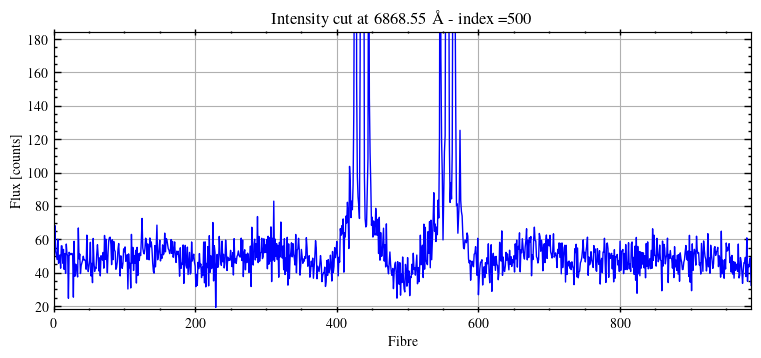

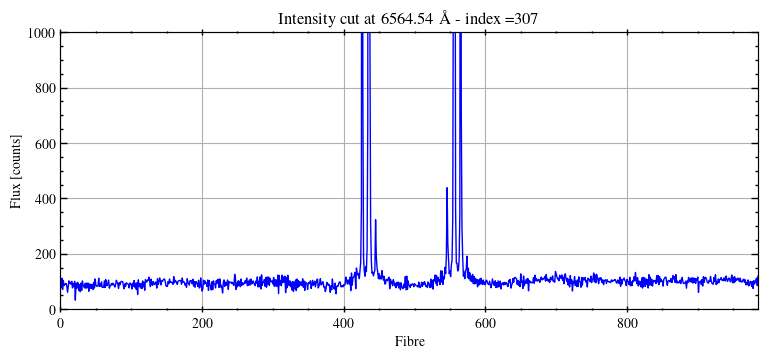

In [13]:
plot_wavelength(run28_red, 500, r=False)          # If wavelength is integer and < wavelength[0], it is an index 
plot_wavelength(run28_red, 6563,                  # This plots the cut closest to 6563, it is in index 307 as says in plot title 
                r=False,
                ymin=0, ymax=1000, extra_y=0)     # Additional plotting adjustments for quick_plot() as kwargs 

 ## Plotting the RSS image

For plotting the rss image, use task rss_image(), see many options in the task. 

By default we use cmap='seismic_r' centered at 0 to check positive values in BLUE and negative values in RED.

Use greyscale = True or greyscale_r = True for plotting in greyscale.

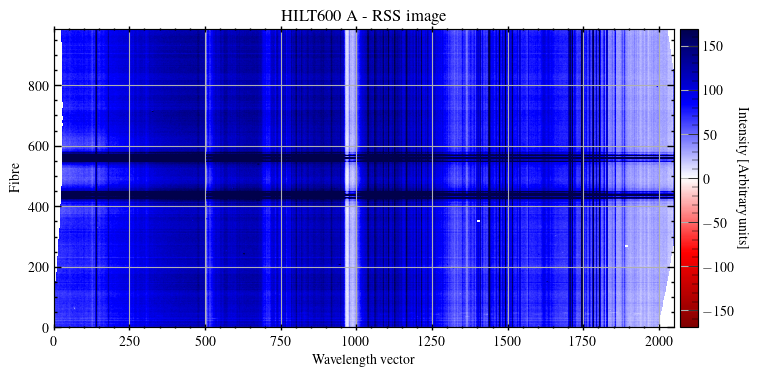

In [14]:
rss_image(run28_red,
          log = False,
          greyscale = False)

It is possible to plot only a subregion:

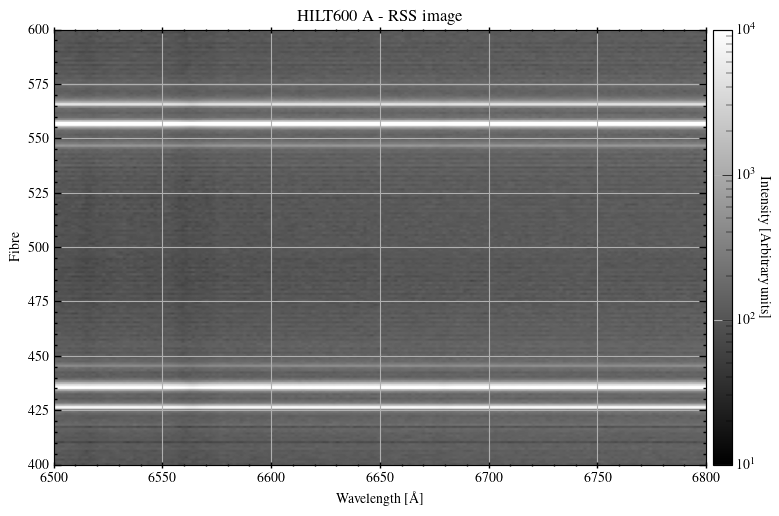

In [15]:
rss_image(run28_red,
          log = True,
          wmin = 6500, wmax = 6800,     # Wavelength range
          fmin = 400, fmax =600,        # Fibre range
          clow = 10, chigh =1E4,        # Color range
          greyscale = True,
          #save_plot_in_file=           # Use this for saving the image in a PNG, PDF file...
          )

 ## Plotting the KOALA RSS map

The task rss_map() plots a map using the integrated value of each fibre. Many options in task:

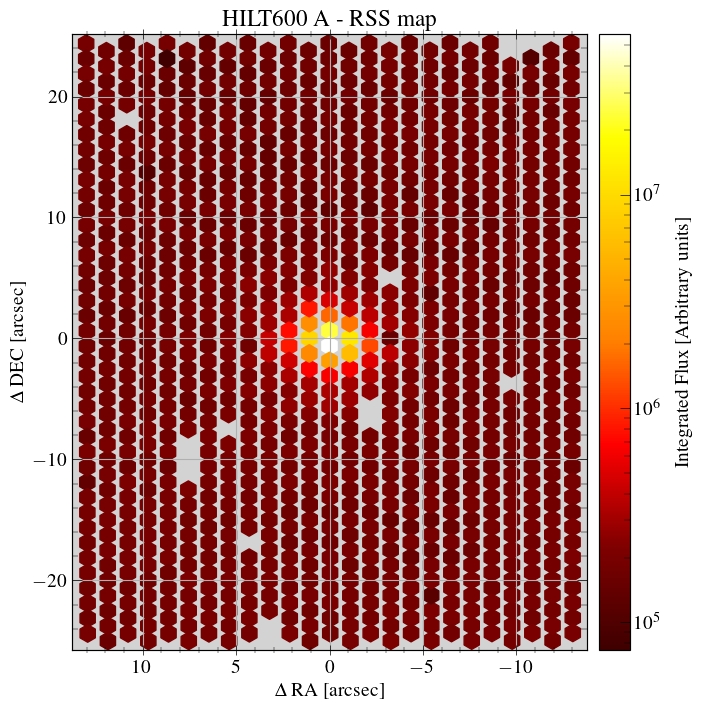

In [16]:
rss_map(run28_red)

# Processing RSS files  - DO NOT RUN FROM HERE !!!

RSS files for KOALA in PyKOALA can easily be processed using ONLY ONE task: process_koala_rss(). This task will perform, in order and as requested:

1. Read the file using koalaRSS, creating .koala object and creating mask
2. Applying the throughput correction (T)
3. Correcting CCD defects (for removing some nans) (C)
4. Small wavelength shift correction (W)
5. Atmospheric extinction correction (X)
6. Telluric correction (red arm) (U)
7. Sky subtraction (several methods included) (S)
8. Check negative sky (over-substracting sky if using self sky spectrum) (N)
9. Emission line identification (E)
10. Cleaning sky residuals (R)
11. Cleaning extreme negative values (R)
12. Cleaning bright cosmic rays not deleted by 2dFdr (R)
13. Save your processed RSS data in fits files.

The details of the processing RSS for science or calibration files are included in tutorial 3. 

Below we provide the info of the most important parameters. 
NOTE: As we have not derived any calibration here, only those procedures that do not need them are True, and of course the resulting RSS will not be good (mainly as we have not applied the throughput).

```python
run28_red=process_koala_rss(rss_object_name="run28_red",                          # Name of the object to be created
                            rss=run28_red,                                        # rss object, if it has been already created
                            #filename=filename,                                   # name of the .fits file
                            #path = path_to_filename,                             # path to the fits file
                            #calibration_night = calibration_night_385R,          # Object with the calibration of the night, if obtained
                            #save_rss_to_fits_file ="clean",                      # save fits file adding "clean" at the end, e.g. "27feb20028red_clean.fits"
                            apply_throughput = False,                             # (T)
                            #throughput=throughput_2D_red,                        # Throughput correction object, included in calibration_night_385R
                            correct_ccd_defects = True,                           # (C)
                            fix_wavelengths = False,                              # (W)
                            #wavelength_shift_correction = wavelength_shift_correction,   # wavelength shift correction object, included in calibration_night_385R 
                            correct_for_extinction = True,                        # (X)
                            apply_telluric_correction=False,                      # (U)
                            #telluric_correction = telluric_correction,           # Telluric correction object, included in calibration_night_385R
                            sky_method = "self",                                  # Sky method to use, in this case using fibres from rss itself
                            correct_negative_sky=True,                            # (N)
                            id_el = False,                                        # (E)  
                            big_telluric_residua_correction = False,              # (R)
                            telluric_residua_at_6860_correction = False,          # (R)
                            correct_extreme_negatives = True,                     # (R)
                            percentile_min_for_extreme_negatives = 0.01,          # As it says
                            clean_cosmics=True,                                   # (R) 
                            only_plot_cosmics_cleaned = True,                     # As it says  

                            verbose_counter = False,                              # Counter does not work on Jypiter
                            plot_final_rss=True, warnings=True, plot = True, verbose = True        # This plots and verbose everything
                            #plot_final_rss=False, warnings=False, plot = False, verbose = False   # This does not plot or verbose (default)
                            )
```                            

# process_koala_rss() with all the options

```python
# Set obs_number to be read
obs_number = 32 #31-36  galaxy He2-10

# Set variable "filename" just with the info of the file (it does not include the path in this example)
filename = f"{date}{aaomega_arms[arm]}00{obs_number}red.fits"     

run32_red=process_koala_rss(rss_object_name="run32_red",                          # Name of the object to be created
                            filename=filename,                                    # name of the .fits file to use
                            path = path_to_filename,                              # path to fits file
                            calibration_night = calibration_night_385R,           # Object with the calibration of the night                        
                            apply_throughput = True,                              # (T)  
                            #throughput=throughput_2D_red,                        # Throughput object, included in calibration_night_385R
                            correct_ccd_defects = True,                           # (C)
                            fix_wavelengths = True,                               # (W)
                            #wavelength_shift_correction = wavelength_shift_correction,   # wavelength shift correction object, included in calibration_night_385R 
                            correct_for_extinction = True,                        # (X)
                            apply_telluric_correction=True,                       # (U)
                            #telluric_correction = telluric_correction,           # Telluric correction object, included in calibration_night_385R
 
                            sky_method = "selffit",                                         # (S) Using the same rss and fitting Gaussians to skylines in each fibre
                            n_sky = 25,                                                     # Using the 25 fibres with lowest intensity...          
                            sky_wave_min=6960,                                              # ... between 6960 ..
                            sky_wave_max=7220,                                              # ... and 7220
                            bright_emission_lines_to_substract_in_sky = [6584],             # List with bright emission lines to substract in sky, typically H-alpha
                            list_of_skylines_to_fit_near_bright_emission_lines = [[6577]],  # List with lists of adjacent skylines we have to consider close to bright emission lines
                            fix_edges = True,                                               # Use information in the rss to fix the red/blue edges in sky spectrum if needed
 
                            correct_negative_sky = True,                  # (N) Check fibres for negative sky
                            id_el = True,                                 # (E) Identify emission lines in combined spectrum of rss
                            big_telluric_residua_correction = True,       # (R) # Fix residua of the big telluric absorption at ~7600 A 
                            correct_extreme_negatives = True,             # (R) Correct for extreme negatives
                            percentile_min_for_extreme_negatives = 0.05,  # Percentile below which extreme negative will be corrected
                            clean_cosmics = True,                         # (R) Clean cosmics
                            max_number_of_cosmics_per_fibre = 15,         # Max number of cosmics to clean per fibre or wavelength, if more than this it does not correct anything.
                            only_plot_cosmics_cleaned = True,             # The only plot that this task will provide, default is False, but use True for minimizing plotting
                              
                            verbose_counter = False,                                               # Counter does not work on Jypiter
                            plot_final_rss=True, warnings=False, plot = True, verbose = True       # This plots and verbose everything
                            #plot_final_rss=False, warnings=False, plot = False, verbose = False   # This does not plot or verbose (default)
                            )
```